# Project 2


In [0]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
import os,time
from pyspark.sql import SparkSession
 
spark = SparkSession.builder.appName("my_project_2").getOrCreate()

## Read Sub Demographic data

In [0]:
demographic_df = spark.read.parquet("dbfs:/FileStore/project_b_data/proj_B_demographic/")
demographic_df.printSchema()
display(demographic_df.limit(10))

root
 |-- household_id: long (nullable = true)
 |-- household_size: integer (nullable = true)
 |-- num_adults: integer (nullable = true)
 |-- num_generations: integer (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- race_code: string (nullable = true)
 |-- dwelling_type: string (nullable = true)
 |-- home_owner_status: string (nullable = true)
 |-- length_residence: integer (nullable = true)
 |-- home_market_value: double (nullable = true)
 |-- net_worth: double (nullable = true)
 |-- gender_individual: string (nullable = true)
 |-- education_highest: string (nullable = true)



household_id,household_size,num_adults,num_generations,marital_status,race_code,dwelling_type,home_owner_status,length_residence,home_market_value,net_worth,gender_individual,education_highest
85,2,1,2,B,W,S,O,15,0.125,0.05,F,1
2073,1,1,2,M,H,S,O,15,0.15,0.1,F,1
2523,7,6,3,M,W,S,O,15,0.1,0.1,M,2
2717,3,2,2,S,W,S,O,11,0.125,0.2,M,3
3364,2,2,2,M,W,S,O,15,0.1,0.1,M,1
4046,4,3,3,M,W,S,O,6,0.075,0.05,F,1
4303,1,1,1,S,W,S,O,15,0.15,0.2,M,1
4559,3,2,2,S,W,S,O,12,0.175,0.2,F,2
5277,3,2,2,M,W,S,R,15,0.125,0.02,M,2
5440,1,1,1,S,W,S,O,8,0.225,0.2,F,1


## Read Static Viewing Data

In [0]:
schema = StructType([
    StructField("device_id", StringType(), True),
    StructField("event_date", StringType(), True),
    StructField("event_time", StringType(), True),     
    StructField("station_num", IntegerType(), True),
    StructField("prog_code", StringType(), True),
    StructField("household_id", IntegerType(), True)
])

viewing_static_df = spark.read.schema(schema).option("header", True).csv("dbfs:/FileStore/project_b_data/viewing_static_csv/")

viewing_static_df.printSchema()
display(viewing_static_df.limit(10))

root
 |-- device_id: string (nullable = true)
 |-- event_date: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- station_num: integer (nullable = true)
 |-- prog_code: string (nullable = true)
 |-- household_id: integer (nullable = true)



device_id,event_date,event_time,station_num,prog_code,household_id
001bd74cc8d1,20150120,181338,75523,EP000009110053,3783713
10ea5940d694,20150120,181338,11218,MV001054110000,3787015
44e08ed80c35,20150120,181338,11713,SH004464010000,43921
0000048de4f2,20150120,181338,65626,MV000506130000,3672067
0000059867a7,20150120,181338,58812,EP019199930005,3645541
000011ff9ba9,20150120,181338,18510,EP010855880111,3642303
00000254e5f6,20150120,181338,35513,EP000369550087,3825751
000002bd8a47,20150120,181338,10035,EP013413450102,2971023
000003c4c597,20150120,181338,59337,MV000744670000,2358722
00407bba00fe,20150120,181338,14771,EP015899250028,2838674


## Static Data Analysis (65 points)

### Feature Extraction

In this section we normalizes numerical columns using min-max scaling and applies one-hot encoding to categorical columns. 

It then combines all processed features into a single vector per household using VectorAssembler, excluding the household_id.

help from chatGPT with building the StringIndexer and OneHotEncoder

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

demographic_df_new = demographic_df

# Step 1: Scaling all numerical columns in Demographic data
numerical_cols = [
    'household_size',
    'num_adults',
    'num_generations',
    'length_residence',
    'home_market_value',
    'net_worth'
]

# Find min and max values for each numerical column
min_max_vals = demographic_df_new.select(
    *[min(col(c)).alias(f"{c}_min") for c in numerical_cols],
    *[max(col(c)).alias(f"{c}_max") for c in numerical_cols]
).collect()[0]

# Normalize numerical columns using min-max scaling to [0, 1] range
for col_name in numerical_cols:
    min_val = min_max_vals[f"{col_name}_min"]
    max_val = min_max_vals[f"{col_name}_max"]
    range_val = max_val - min_val if max_val != min_val else 1  # avoid division by zero

    demographic_df_new = demographic_df_new.withColumn(
        f"{col_name}_normalized",
        (col(col_name) - lit(min_val)) / lit(range_val)
    )

# Step 2: Creating one-hot encoding for categorical columns 
categorical_cols = [
    "marital_status",
    "race_code",
    "dwelling_type",
    "home_owner_status",
    "gender_individual",
    "education_highest"
]

df = demographic_df_new  

# Help from chatGPT with building the StringIndexer and OneHotEncoder
for col_name in categorical_cols:
    # Convert string categories to numerical indices
    indexer = StringIndexer(
        inputCol=col_name,
        outputCol=col_name + "_index",
        handleInvalid="skip"  # skip rows with null or unseen categories
    )
    df = indexer.fit(df).transform(df)
    
    # Convert indices to one-hot encoded vectors
    encoder = OneHotEncoder(
        inputCol=col_name + "_index",
        outputCol=col_name + "_vec"
    )
    df = encoder.fit(df).transform(df)

# Step 3: Combine normalized numeric and one-hot encoded categorical columns into one feature vector
encoded_vec_cols = [col + "_vec" for col in categorical_cols]
normalized_cols = [col + "_normalized" for col in numerical_cols]

assembler = VectorAssembler(
    inputCols=normalized_cols + encoded_vec_cols,
    outputCol="features"
)

df = assembler.transform(df)

# Show results
display(df.select("household_id", "features").limit(7))


🏃 View run placid-hawk-918 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769/runs/dde618e83dd04759b0a78b08e02556a3
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769
🏃 View run defiant-penguin-75 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769/runs/4a019b8a50f94894b6bb18803d26dc70
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769
🏃 View run righteous-crab-44 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769/runs/4c945cba450f403c99c5cd38a50e58ab
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769
🏃 View run trusting-sow-358 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769/runs/980e107c247b4956b7ca3170ee27bf99
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648

household_id,features
85,"Map(vectorType -> sparse, length -> 18, indices -> List(0, 2, 3, 4, 5, 9, 12, 13, 15), values -> List(0.125, 0.5, 1.0, 0.12412412412412413, 0.05, 1.0, 1.0, 1.0, 1.0))"
2073,"Map(vectorType -> sparse, length -> 18, indices -> List(2, 3, 4, 5, 6, 11, 12, 13, 15), values -> List(0.5, 1.0, 0.14914914914914915, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0))"
2523,"Map(vectorType -> dense, length -> 18, values -> List(0.75, 1.0, 1.0, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0))"
2717,"Map(vectorType -> dense, length -> 18, values -> List(0.25, 0.2, 0.5, 0.7333333333333333, 0.12412412412412413, 0.2, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0))"
3364,"Map(vectorType -> dense, length -> 18, values -> List(0.125, 0.2, 0.5, 1.0, 0.0990990990990991, 0.1, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0))"
4046,"Map(vectorType -> dense, length -> 18, values -> List(0.375, 0.4, 1.0, 0.4, 0.07407407407407407, 0.05, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0))"
4303,"Map(vectorType -> sparse, length -> 18, indices -> List(3, 4, 5, 7, 9, 12, 13, 14, 15), values -> List(1.0, 0.14914914914914915, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))"


### Visual Analysis

In this section we uses PCA (Principal Component Analysis) to reduce 
the high-dimensional feature vectors of the demographic dataset 

into two 
dimensions (R²). 

After applying PCA with k=2, the resulting two components for each household are extracted and plotted as a 2D scatter plot.

This visual representation helps identify natural groupings (clusters) in the data.





🏃 View run merciful-bat-868 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769/runs/5752914735d1495d929c9088a40bb945
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769
+------------+--------------------+---------------------+
|household_id|x                   |y                    |
+------------+--------------------+---------------------+
|85          |0.7696161667682871  |-0.14328450444326643 |
|2073        |1.0470607429479681  |-0.8077002155153677  |
|2523        |-0.21564461720439165|-1.6496380625532223  |
|2717        |-0.1472713333051469 |-0.009878108533881512|
|3364        |1.0866265581511059  |-1.0202633541472945  |
|4046        |0.9640643076197233  |-0.95014832062263    |
|4303        |0.685225856582358   |0.33186218098407516  |
+------------+--------------------+---------------------+
only showing top 7 rows



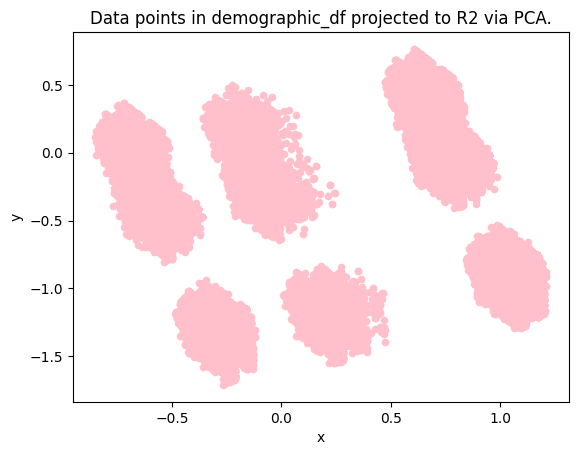

In [0]:
from pyspark.ml.feature import PCA 
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.functions import vector_to_array

# Step 1: Apply PCA to reduce the feature vectors from high dimension to 2D (R²)
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(df)
pca_df = model.transform(df)

# Convert PCA vector result into an array for easier access
pca_df = pca_df.withColumn("pca_array", vector_to_array("pca_features"))

# Extract household_id, x and y coordinates from the PCA result
proj_df = pca_df.select(
    col("household_id"),
    col("pca_array")[0].alias("x"),
    col("pca_array")[1].alias("y")
)

# Show household_id with its 2D coordinates
proj_df.show(7, truncate=False)

# Step 2: Convert to pandas and plot the households in 2D using the PCA results
pdf = proj_df.toPandas().plot.scatter(x="x", y="y", color="pink")
plt.title("Data points in demographic_df projected to R2 via PCA.")
plt.xlabel("x")
plt.ylabel("y")
plt.show()




### Clustering

In this section, we apply the K-means clustering algorithm with c = 6
to group households based on their feature vectors. 
  
After assigning each household to a cluster, we calculate the Euclidean distance between each household’s feature vector and its corresponding cluster centroid. 

Two new columns are added to the DataFrame: one indicating the assigned cluster label, and another showing the distance from the centroid.

Help from chatGPT to create UDF function "distance_from_center" and to use it correctly in step 3












In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# Step 1: Run K-means on "features" vectors from demographic_df
kmeans = KMeans(k=6, seed=3, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df)
clustered_df = model.transform(df)

# Step 2: Compute distances of households to their centroids 

# Get cluster centers
centroids = model.clusterCenters()

#Help from chatGPT to create UDF function "distance_from_center" and to use it correctly in step 3
# Define UDF to compute Euclidean distance to the cluster centroid
def distance_from_center(features, cluster_id):
    centroid = centroids[cluster_id]
    return float(Vectors.squared_distance(features, centroid))**0.5

euclidean_distance_udf = udf(distance_from_center, DoubleType())

# Step 3: Add column of distance of household from their centroid
clustered_df = clustered_df.withColumn(
    "distance_from_centroid",
    euclidean_distance_udf(col("features"), col("cluster"))
)

# Show results
clustered_df.select("household_id", "cluster", "distance_from_centroid").show(7, truncate=False)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

🏃 View run classy-newt-136 at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769/runs/e66ff43d4a334ed0850a421785eeaef3
🧪 View experiment at: https://adb-385435138940782.2.azuredatabricks.net/ml/experiments/30648897007769
+------------+-------+----------------------+
|household_id|cluster|distance_from_centroid|
+------------+-------+----------------------+
|85          |1      |0.9568649711438205    |
|2073        |2      |0.8481485938466666    |
|2523        |0      |1.3296410205779299    |
|2717        |1      |1.4315091453110262    |
|3364        |5      |0.58615854643112      |
|4046        |5      |0.9358106506190059    |
|4303        |1      |0.9705720982818974    |
+------------+-------+----------------------+
only showing top 7 rows



### Dividing households into subsets

In this section, we rank households within each cluster by their distance to the cluster centroid, with closer households receiving lower ranks. 

Based on this ranking, we create three subsets for each cluster: 

the full set containing all households, a 3rds subset that includes every third household in each cluster, and a 17ths subset that includes every seventeenth. 

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col, lit

# Step 1: Create ranking of households in each cluster

# Define a window that partitions the data by cluster and orders by distance from centroid (ascending)
window_partition = Window.partitionBy("cluster").orderBy(col("distance_from_centroid").asc())

# Add a rank column within each cluster based on proximity to the centroid
ranked_df = clustered_df.withColumn("rank", row_number().over(window_partition))

# Step 2: Create each subset separately

# Full subset: includes all households
full_subset = ranked_df.withColumn("subset", lit("Full"))
full_subset = full_subset.select("household_id","cluster", "distance_from_centroid" ,"rank")
print ("Full subset:")
full_subset.show(20, truncate=False)

# Thirds subset: includes households ranked in positions divisible by 3
thirds_subset = ranked_df.filter((col("rank") % 3) == 0).withColumn("subset", lit("3rds"))
thirds_subset = thirds_subset.select("household_id","cluster", "distance_from_centroid" ,"rank")
print ("Thirds subset:")
thirds_subset.show(20, truncate=False)

# Seventeenths subset: includes households ranked in positions divisible by 17
seventeenths_subset = ranked_df.filter((col("rank") % 17) == 0).withColumn("subset", lit("17ths"))
seventeenths_subset = seventeenths_subset.select("household_id","cluster", "distance_from_centroid" ,"rank")
print ("Seventeenths subset:")
seventeenths_subset.show(20, truncate=False)


Full subset:
+------------+-------+----------------------+----+
|household_id|cluster|distance_from_centroid|rank|
+------------+-------+----------------------+----+
|1996154     |5      |0.5160337851765171    |1   |
|4023076     |5      |0.5160337851765171    |2   |
|2076499     |5      |0.5163706094977986    |3   |
|2197121     |5      |0.5163706094977986    |4   |
|2828482     |5      |0.5163706094977986    |5   |
|76184       |5      |0.5163706094977986    |6   |
|3622774     |5      |0.5163706094977986    |7   |
|2312160     |5      |0.5164392231860736    |8   |
|15801       |5      |0.5164392231860736    |9   |
|21077       |5      |0.5164392231860736    |10  |
|1593116     |5      |0.5164392231860736    |11  |
|2121015     |5      |0.5164392231860736    |12  |
|4026311     |5      |0.5164392231860736    |13  |
|382240      |5      |0.5165956509786228    |14  |
|3615832     |5      |0.5165956509786228    |15  |
|20353       |5      |0.5165956509786228    |16  |
|8663        |5   

### Cluster’s Viewing Analysis

In this section we calculate the top 7 stations per cluster for each subset (Full, 3rds, 17ths) by comparing their viewing share in the subset to the general audience (diff rank) and ranking the most overrepresented stations.

In [0]:
# Join each subset with viewing data and cache
viewing_full = viewing_static_df.join(full_subset, "household_id", "inner").cache()
viewing_thirds = viewing_static_df.join(thirds_subset, "household_id", "inner").cache()
viewing_seventeenths = viewing_static_df.join(seventeenths_subset, "household_id", "inner").cache()

# Count views per (cluster, station) pair in each subset
counts_full = viewing_full.groupBy("cluster", "station_num").count()
counts_thirds = viewing_thirds.groupBy("cluster", "station_num").count()
counts_seventeenths = viewing_seventeenths.groupBy("cluster", "station_num").count()

# Compute total views per cluster
totals_full = counts_full.groupBy("cluster").agg(sum("count").alias("total"))
totals_thirds = counts_thirds.groupBy("cluster").agg(sum("count").alias("total"))
totals_seventeenths = counts_seventeenths.groupBy("cluster").agg(sum("count").alias("total"))

# Compute station view percentage within each cluster
percentages_full = counts_full.join(totals_full, "cluster").withColumn("subset_rating", (col("count")/col("total")) * 100)
percentages_thirds = counts_thirds.join(totals_thirds, "cluster").withColumn("subset_rating", (col("count")/col("total")) * 100)
percentages_seventeenths = counts_seventeenths.join(totals_seventeenths, "cluster").withColumn("subset_rating", (col("count")/col("total")) * 100)

# Compute global station viewing percentages across all clusters
general_counts = viewing_static_df.groupBy("station_num").count().cache()
total_views = viewing_static_df.count()
general_percentages = general_counts.withColumn("general_rating", (col("count")/total_views)*100)

# Compute over/under-representation of each station in subset compared to general audience
diff_full = percentages_full.join(general_percentages, "station_num", "inner").withColumn("diff_rank", col("subset_rating") - col("general_rating")).withColumn("subset", lit("Full"))
diff_thirds = percentages_thirds.join(general_percentages, "station_num", "inner").withColumn("diff_rank", col("subset_rating") - col("general_rating")).withColumn("subset", lit("Thirds"))
diff_seventeenths = percentages_seventeenths.join(general_percentages, "station_num", "inner").withColumn("diff_rank", col("subset_rating") - col("general_rating")).withColumn("subset", lit("Seventeenths"))

# Rank top 7 stations per cluster based on diff_rank for each subset
ranked_dfs = {}
for subset_name, df in [("Full", diff_full), ("3rds", diff_thirds), ("17ths", diff_seventeenths)]:
    window = Window.partitionBy("cluster").orderBy(col("diff_rank").desc())
    ranked_dfs[subset_name] = df.withColumn("rank", row_number().over(window)).filter(col("rank") <= 7).cache()

clusters = [row["cluster"] for row in clustered_df.select("cluster").distinct().orderBy("cluster").collect()]

# Display top 7 stations for each subset per cluster
for cluster in clusters:
    for subset_name in ["Full", "3rds", "17ths"]:
        print(f"\nCluster {cluster} - {subset_name} Subset:")
        ranked_dfs[subset_name].filter(col("cluster") == cluster).orderBy(col("rank")).select("rank", "station_num", "diff_rank", "subset", "cluster").show(truncate=False)






Cluster 0 - Full Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |60179      |0.3920006870166719 |Full  |0      |
|2   |16374      |0.22730308873892513|Full  |0      |
|3   |49788      |0.2045526380494167 |Full  |0      |
|4   |32645      |0.1001779326043215 |Full  |0      |
|5   |10335      |0.08745533979025041|Full  |0      |
|6   |50747      |0.08060981371936737|Full  |0      |
|7   |61854      |0.07566834124361119|Full  |0      |
+----+-----------+-------------------+------+-------+


Cluster 0 - 3rds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |60179      |0.3132955120556835 |Thirds|0      |
|2   |32645      |0.2107189555727429 |Thirds|0      |
|3   |16374      |0.15516131079273898|Thirds|0      |
|4   |49788      |0.146409989

## Dynamic Data Analysis - Streaming (35 points)

In this section we process each batch of streaming data, incrementally aggregating results across batches and calculating the top stations per cluster for the Thirds subset, based on their difference in popularity from the general population (diff rank).

Given starter code for proccessing streaming data:

In [0]:
SCHEMA = "device_id STRING, event_date INT, event_time INT, station_num STRING, prog_code STRING, household_id STRING"
kafka_server = "kafka.eastus.cloudapp.azure.com:29092"
topic = "view_data" 
OFFSETS_PER_TRIGGER = 50000

streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER)\
                  .load()\
                  .select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")


########## QUERY EXAMPLE ##########

station_counts = streaming_df.groupBy("station_num").count()

count_viewings_per_station_query =station_counts.writeStream\
.queryName('num_viewing')\
.format("memory")\
.outputMode("complete")\
.start()

time.sleep(10)

for i in range(10):
    print("Batch number: "+str(i))
    print(count_viewings_per_station_query.status)
    spark.sql('SELECT * FROM num_viewing ORDER BY count DESC LIMIT 10').show()
    time.sleep(5)
    
count_viewings_per_station_query.stop()

Batch number: 0
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
+-----------+-----+

Batch number: 1
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
+-----------+-----+

Batch number: 2
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
+-----------+-----+

Batch number: 3
{'message': 'Processing new data', 'isDataAvailable': True, 'isTriggerActive': True}
+-----------+-----+
|station_num|count|
+-----------+-----+
|      32645| 1288|
|      11221|  795|
|      10179|  783|
|      11187|  763|
|      11713|  757|
|      10171|  590|
|      14771|  584|
|      10035|  578|
|      11150|  549|
|      49788|  545|
+-----------+-----+

Batch number: 4
{'message': 'Processing new data', 'isDataAvailable': Tr

Using the streaming input from the starter code, we implement a function that incrementally aggregates data across batches, filters for the Thirds subset, and calculates the top 7 stations per cluster based on their diff rank compared to the general population.

We used ChatGPT's help to adapt the logic to work with aggregated data across all batches rather than processing each batch independently.

In [0]:
# Initialize global variables for aggregation and query control (ChatGPT assistence)
aggregated_df = None
query = None
def process_batch(df, epoch_id):
    global aggregated_df, query
    
    # Stop the query after 3 batches have been processed
    if epoch_id >= 3 and query is not None:
        query.stop()
        return
    
    # Aggregate streaming data across batches
    if aggregated_df is None:
        aggregated_df = df
    else:
        aggregated_df = aggregated_df.union(df).cache()
    print(f"Batch number {epoch_id}:")
    
    # Calculate ratings for each cluster based on diff_rank for the Thirds subset
    window = Window.partitionBy("cluster").orderBy(col("diff_rank").desc())
    streaming_thirds = aggregated_df.join(thirds_subset, "household_id", "inner")
    counts_thirds = streaming_thirds.groupBy("cluster", "station_num").count()
    totals_thirds = counts_thirds.groupBy("cluster").agg(sum("count").alias("total"))
    percentages_thirds = counts_thirds.join(totals_thirds, "cluster").withColumn("subset_rating", (col("count")/col("total")) * 100)

    # Calculate general population popularity for each station
    general_counts = aggregated_df.groupBy("station_num").count()
    total_views = aggregated_df.count()
    general_percentages = general_counts.withColumn("general_rating", (col("count")/total_views)*100)

    # Compute diff rank
    diff_thirds = percentages_thirds.join(general_percentages, "station_num", "inner").withColumn("diff_rank", col("subset_rating") - col("general_rating")).withColumn("subset", lit("Thirds"))
    ranked_df = diff_thirds.withColumn("rank", row_number().over(window)).filter(col("rank") <= 7).cache()
    
    # Display top stations for each cluster
    clusters = [row["cluster"] for row in ranked_df.select("cluster").distinct().orderBy("cluster").collect()]
    for cluster in clusters:
        print(f"\nBatch {epoch_id} - Cluster {cluster} - Thirds Subset:")
        ranked_df.filter(col("cluster") == cluster).orderBy(col("rank")).select("rank", "station_num", "diff_rank", "subset", "cluster").show(truncate=False)

# Start the streaming query and process batches
query = streaming_df.writeStream\
                  .foreachBatch(process_batch)\
                  .start()
query.awaitTermination(20)


Batch number 0:

Batch 0 - Cluster 0 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |32645      |0.6854704256495299|Thirds|0      |
|2   |11150      |0.5880143725815365|Thirds|0      |
|3   |14771      |0.4350956329463793|Thirds|0      |
|4   |11164      |0.3883040353786623|Thirds|0      |
|5   |19630      |0.3829894969596462|Thirds|0      |
|6   |10179      |0.3687705914870092|Thirds|0      |
|7   |16123      |0.3309894969596462|Thirds|0      |
+----+-----------+------------------+------+-------+


Batch 0 - Cluster 1 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |15433      |0.4512606246799795 |Thirds|1      |
|2   |10145      |0.3404884792626728 |Thirds|1      |
|3   |11765      |0.32164260112647214|Thirds|1      |


False

Full output from the driver logs:

```
Batch number 0:

Batch 0 - Cluster 0 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |32645      |0.6854704256495299|Thirds|0      |
|2   |11150      |0.5880143725815365|Thirds|0      |
|3   |14771      |0.4350956329463793|Thirds|0      |
|4   |11164      |0.3883040353786623|Thirds|0      |
|5   |19630      |0.3829894969596462|Thirds|0      |
|6   |10179      |0.3687705914870092|Thirds|0      |
|7   |16123      |0.3309894969596462|Thirds|0      |
+----+-----------+------------------+------+-------+


Batch 0 - Cluster 1 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |15433      |0.4512606246799795 |Thirds|1      |
|2   |10145      |0.3404884792626728 |Thirds|1      |
|3   |11765      |0.32164260112647214|Thirds|1      |
|4   |50001      |0.31762621607782904|Thirds|1      |
|5   |14771      |0.3168950332821303 |Thirds|1      |
|6   |18001      |0.2876344086021506 |Thirds|1      |
|7   |55887      |0.26163440860215065|Thirds|1      |
+----+-----------+-------------------+------+-------+


Batch 0 - Cluster 2 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |18480      |1.8490204081632653|Thirds|2      |
|2   |10179      |1.4952244897959182|Thirds|2      |
|3   |10989      |1.186612244897959 |Thirds|2      |
|4   |32645      |1.1654965986394559|Thirds|2      |
|5   |17927      |1.024612244897959 |Thirds|2      |
|6   |11118      |0.9804081632653061|Thirds|2      |
|7   |10918      |0.932748299319728 |Thirds|2      |
+----+-----------+------------------+------+-------+


Batch 0 - Cluster 3 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |10918      |2.6395127768313458|Thirds|3      |
|2   |10171      |1.630902896081772 |Thirds|3      |
|3   |10057      |1.2619352640545145|Thirds|3      |
|4   |35513      |1.112862010221465 |Thirds|3      |
|5   |10021      |1.1023986371379897|Thirds|3      |
|6   |10179      |1.0745451448040886|Thirds|3      |
|7   |10559      |0.9196831345826234|Thirds|3      |
+----+-----------+------------------+------+-------+


Batch 0 - Cluster 4 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |11221      |2.1137037037037034|Thirds|4      |
|2   |49788      |1.3791358024691356|Thirds|4      |
|3   |16300      |1.347668430335097 |Thirds|4      |
|4   |12131      |1.2727689594356257|Thirds|4      |
|5   |10918      |1.1784021164021163|Thirds|4      |
|6   |10222      |1.1745679012345678|Thirds|4      |
|7   |10162      |0.9642010582010582|Thirds|4      |
+----+-----------+------------------+------+-------+


Batch 0 - Cluster 5 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |31258      |0.4700201394268009 |Thirds|5      |
|2   |58812      |0.33808520526723473|Thirds|5      |
|3   |16331      |0.3046909372579396 |Thirds|5      |
|4   |16616      |0.2906258714175059 |Thirds|5      |
|5   |14753      |0.2877722695584818 |Thirds|5      |
|6   |10161      |0.2638048024786987 |Thirds|5      |
|7   |19606      |0.26177226955848176|Thirds|5      |
+----+-----------+-------------------+------+-------+

Batch number 1:

Batch 1 - Cluster 0 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |60179      |0.6251536447567865 |Thirds|0      |
|2   |12574      |0.40092531349042315|Thirds|0      |
|3   |31709      |0.3236505443020533 |Thirds|0      |
|4   |14771      |0.3234202838638558 |Thirds|0      |
|5   |11158      |0.29924652060079926|Thirds|0      |
|6   |21251      |0.2912929585228055 |Thirds|0      |
|7   |11150      |0.2874384731982913 |Thirds|0      |
+----+-----------+-------------------+------+-------+


Batch 1 - Cluster 1 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |11069      |0.40923488045007034|Thirds|1      |
|2   |19933      |0.40866270297915874|Thirds|1      |
|3   |12852      |0.2934487917146145 |Thirds|1      |
|4   |16300      |0.290807057920982  |Thirds|1      |
|5   |11344      |0.2825931466564378 |Thirds|1      |
|6   |11913      |0.22258266206367475|Thirds|1      |
|7   |15433      |0.20122963815368877|Thirds|1      |
+----+-----------+-------------------+------+-------+


Batch 1 - Cluster 2 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |32645      |1.677267080745342 |Thirds|2      |
|2   |10989      |1.1947950310559006|Thirds|2      |
|3   |59684      |1.1867142857142856|Thirds|2      |
|4   |18480      |1.1457142857142855|Thirds|2      |
|5   |59337      |1.1197950310559008|Thirds|2      |
|6   |10918      |1.0413540372670806|Thirds|2      |
|7   |12510      |0.9915962732919255|Thirds|2      |
+----+-----------+------------------+------+-------+


Batch 1 - Cluster 3 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |10171      |1.8335507246376812|Thirds|3      |
|2   |10918      |1.745287784679089 |Thirds|3      |
|3   |35513      |1.4147225672877846|Thirds|3      |
|4   |10057      |1.1841304347826087|Thirds|3      |
|5   |10021      |1.174761904761905 |Thirds|3      |
|6   |10559      |1.0870910973084884|Thirds|3      |
|7   |11097      |0.8698674948240166|Thirds|3      |
+----+-----------+------------------+------+-------+


Batch 1 - Cluster 4 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |49788      |1.5924773960216998|Thirds|4      |
|2   |45980      |1.1638227848101266|Thirds|4      |
|3   |12131      |1.1155660036166366|Thirds|4      |
|4   |16300      |1.0990705244122965|Thirds|4      |
|5   |17927      |1.09348643761302  |Thirds|4      |
|6   |51529      |1.03748643761302  |Thirds|4      |
|7   |10171      |0.9241500904159132|Thirds|4      |
+----+-----------+------------------+------+-------+


Batch 1 - Cluster 5 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |11713      |0.6711030967642289 |Thirds|5      |
|2   |14902      |0.3959077921074985 |Thirds|5      |
|3   |16374      |0.24873310680361405|Thirds|5      |
|4   |10642      |0.23247270059464054|Thirds|5      |
|5   |16616      |0.2110857209050893 |Thirds|5      |
|6   |11221      |0.20720580739825434|Thirds|5      |
|7   |51529      |0.18226040620897366|Thirds|5      |
+----+-----------+-------------------+------+-------+

Batch number 2:

Batch 2 - Cluster 0 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |11150      |0.45366361704093894|Thirds|0      |
|2   |32645      |0.35303391553460894|Thirds|0      |
|3   |12574      |0.30753202107014144|Thirds|0      |
|4   |16752      |0.2687758987154607 |Thirds|0      |
|5   |49788      |0.25290749468625817|Thirds|0      |
|6   |31709      |0.2382236392200352 |Thirds|0      |
|7   |11913      |0.22167396728583313|Thirds|0      |
+----+-----------+-------------------+------+-------+


Batch 2 - Cluster 1 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |11344      |0.3738567792295945 |Thirds|1      |
|2   |11765      |0.3247714237230613 |Thirds|1      |
|3   |10145      |0.2814859437751005 |Thirds|1      |
|4   |41536      |0.2761092821992194 |Thirds|1      |
|5   |11097      |0.274466542225239  |Thirds|1      |
|6   |18480      |0.26719237513434024|Thirds|1      |
|7   |87317      |0.253747497030375  |Thirds|1      |
+----+-----------+-------------------+------+-------+


Batch 2 - Cluster 2 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |59684      |1.2969193548387097|Thirds|2      |
|2   |10222      |1.1760806451612902|Thirds|2      |
|3   |10989      |0.9698172043010753|Thirds|2      |
|4   |12510      |0.8878010752688171|Thirds|2      |
|5   |45980      |0.8032580645161291|Thirds|2      |
|6   |12131      |0.7917096774193547|Thirds|2      |
|7   |14321      |0.7603602150537634|Thirds|2      |
+----+-----------+------------------+------+-------+


Batch 2 - Cluster 3 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |10918      |1.5582865013774105|Thirds|3      |
|2   |10057      |1.3150633608815427|Thirds|3      |
|3   |10559      |1.2793223140495869|Thirds|3      |
|4   |10171      |1.2027603305785124|Thirds|3      |
|5   |35513      |1.1349586776859504|Thirds|3      |
|6   |10021      |1.0484187327823689|Thirds|3      |
|7   |11809      |1.03233608815427  |Thirds|3      |
+----+-----------+------------------+------+-------+


Batch 2 - Cluster 4 - Thirds Subset:
+----+-----------+------------------+------+-------+
|rank|station_num|diff_rank         |subset|cluster|
+----+-----------+------------------+------+-------+
|1   |10222      |1.256645947592931 |Thirds|4      |
|2   |10918      |1.1884253503961002|Thirds|4      |
|3   |49788      |1.0772407068860452|Thirds|4      |
|4   |45980      |0.9319536867763559|Thirds|4      |
|5   |10171      |0.8212151127361365|Thirds|4      |
|6   |12131      |0.7842766605728214|Thirds|4      |
|7   |17927      |0.7414357099329676|Thirds|4      |
+----+-----------+------------------+------+-------+


Batch 2 - Cluster 5 - Thirds Subset:
+----+-----------+-------------------+------+-------+
|rank|station_num|diff_rank          |subset|cluster|
+----+-----------+-------------------+------+-------+
|1   |19606      |0.29836202389225314|Thirds|5      |
|2   |11713      |0.21836103113934957|Thirds|5      |
|3   |11458      |0.20038366590555612|Thirds|5      |
|4   |60179      |0.17125986961845197|Thirds|5      |
|5   |16331      |0.1571808464873093 |Thirds|5      |
|6   |59976      |0.1478330851451074 |Thirds|5      |
|7   |11007      |0.14034759588338458|Thirds|5      |
+----+-----------+-------------------+------+-------+

```
